In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:

import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [36]:
import os
os.chdir('/content/drive/MyDrive/train_data')
os.chdir('/content/drive/MyDrive/test_data')

In [37]:
from glob import glob
test_folders=glob('/content/drive/MyDrive/test_data/test/*')
test_folders

['/content/drive/MyDrive/test_data/test/COVID19',
 '/content/drive/MyDrive/test_data/test/NORMAL',
 '/content/drive/MyDrive/test_data/test/PNEUMONIA']

In [38]:
train_folders=glob('/content/drive/MyDrive/train_data/train/*')
train_folders

['/content/drive/MyDrive/train_data/train/PNEUMONIA',
 '/content/drive/MyDrive/train_data/train/COVID19',
 '/content/drive/MyDrive/train_data/train/NORMAL']

In [39]:
train_covid = '/content/drive/MyDrive/train_data/train/COVID19/'
train_normal = '/content/drive/MyDrive/train_data/train/NORMAL/'
train_pneumonia = '/content/drive/MyDrive/train_data/train/PNEUMONIA/'

test_covid = '/content/drive/MyDrive/test_data/test/COVID19/'
test_normal = '/content/drive/MyDrive/test_data/test/NORMAL/'
test_pneumonia = '/content/drive/MyDrive/test_data/test/PNEUMONIA/'

In [40]:
print("Number of COVID19 images:", len(os.listdir(test_covid)))
print("Number of Normal images:", len(os.listdir(test_normal)))
print("Number of Pneumonia images:", len(os.listdir(test_pneumonia)))


Number of COVID19 images: 116
Number of Normal images: 317
Number of Pneumonia images: 855


In [41]:
print("Number of COVID19 images:", len(os.listdir(train_covid)))
print("Number of Normal images:", len(os.listdir(train_normal)))
print("Number of Pneumonia images:", len(os.listdir(train_pneumonia)))


Number of COVID19 images: 460
Number of Normal images: 1269
Number of Pneumonia images: 3441


In [42]:
os.listdir(train_covid)[:10]

['COVID19(154).jpg',
 'COVID19(41).jpg',
 'COVID19(213).jpg',
 'COVID19(195).jpg',
 'COVID19(43).jpg',
 'COVID19(114).jpg',
 'COVID19(231).jpg',
 'COVID19(177).jpg',
 'COVID19(140).jpg',
 'COVID19(203).jpg']

In [43]:
def resize_and_normalize_images(data_directory, label_value):
    images = []
    labels = []

    for image in tqdm(os.listdir(data_directory)):
        file_path = os.path.join(data_directory, image)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, (50, 50))
            img = img / 255.0
            images.append(img)
            labels.append(label_value)

    return np.array(images), np.array(labels)

In [44]:
train_covid_images, train_covid_labels = resize_and_normalize_images(train_covid, 0)
train_normal_images, train_normal_labels = resize_and_normalize_images(train_normal, 1)
train_pneumonia_images, train_pneumonia_labels = resize_and_normalize_images(train_pneumonia, 2)

100%|██████████| 3441/3441 [02:57<00:00, 19.33it/s]


In [45]:
train_covid_images.shape

(460, 50, 50, 3)

In [46]:
test_covid_images, test_covid_labels = resize_and_normalize_images(test_covid, 0)
test_normal_images, test_normal_labels = resize_and_normalize_images(test_normal, 1)
test_pneumonia_images, test_pneumonia_labels = resize_and_normalize_images(test_pneumonia, 2)

100%|██████████| 855/855 [00:28<00:00, 29.81it/s]


In [47]:
test_covid_images.shape

(116, 50, 50, 3)

Text(0.5, 1.0, 'Pneumonia')

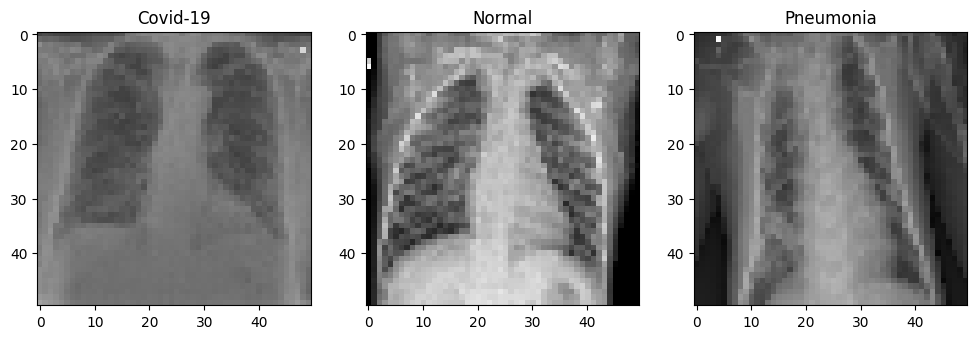

In [48]:
fig, ax = plt.subplots(1, 3, figsize = (12, 8))

ax[0].imshow(train_covid_images[0])
ax[0].set_title("Covid-19")

ax[1].imshow(train_normal_images[0])
ax[1].set_title("Normal")

ax[2].imshow(train_pneumonia_images[0])
ax[2].set_title("Pneumonia")

Text(0.5, 1.0, 'Pneumonia')

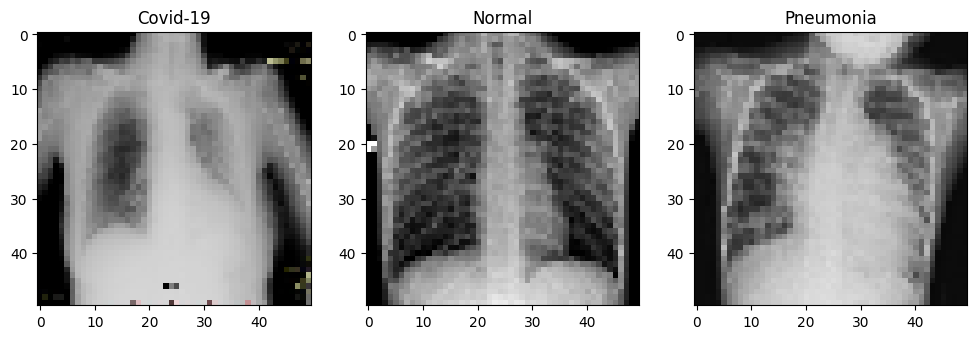

In [49]:
fig, ax = plt.subplots(1, 3, figsize = (12, 8))

ax[0].imshow(test_covid_images[0])
ax[0].set_title("Covid-19")

ax[1].imshow(test_normal_images[0])
ax[1].set_title("Normal")

ax[2].imshow(test_pneumonia_images[0])
ax[2].set_title("Pneumonia")

In [50]:
X_train = np.concatenate((train_covid_images, train_normal_images, train_pneumonia_images))
y_train = np.concatenate((train_covid_labels, train_normal_labels, train_pneumonia_labels))

X_test = np.concatenate((test_covid_images, test_normal_images, test_pneumonia_images))
y_test = np.concatenate((test_covid_labels, test_normal_labels, test_pneumonia_labels))


In [51]:
X_train.shape

(5170, 50, 50, 3)

In [52]:
y_train.shape

(5170,)

In [53]:
X_test.shape

(1288, 50, 50, 3)

In [54]:
tf.keras.backend.clear_session()
input_shape = (50, 50, 3)
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

base_model.trainable = False


model_vgg16 = keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(layers.GlobalAveragePooling2D())
model_vgg16.add(layers.Dense(256, activation='relu'))
model_vgg16.add(layers.Dense(256, activation='relu'))
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(3, activation='softmax'))

opt = keras.optimizers.Adam(0.001)
loss=keras.losses.SparseCategoricalCrossentropy(from_logits= False)
model_vgg16.compile(loss=loss, optimizer=opt, metrics=['accuracy'])


model_vgg16.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                        

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint('model/vgg16_best.h5', monitor='accuracy', verbose=1, mode='max',save_best_only=True)
history=model_vgg16.fit(X_train, y_train,epochs=50,batch_size=64,validation_split=0.2, callbacks=[checkpoint,early_stopping])

Epoch 1/50
65/65 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.8247
Epoch 1: accuracy improved from -inf to 0.82471, saving model to model/vgg16_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 152s 2s/step - loss: 0.4384 - accuracy: 0.8247 - val_loss: 0.1947 - val_accuracy: 0.9284
Epoch 2/50
65/65 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9091
Epoch 2: accuracy improved from 0.82471 to 0.90909, saving model to model/vgg16_best.h5
65/65 [==============================] - 133s 2s/step - loss: 0.2411 - accuracy: 0.9091 - val_loss: 0.1063 - val_accuracy: 0.9681
Epoch 3/50
65/65 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9200
Epoch 3: accuracy improved from 0.90909 to 0.91997, saving model to model/vgg16_best.h5
65/65 [==============================] - 155s 2s/step - loss: 0.2047 - accuracy: 0.9200 - val_loss: 0.2126 - val_accuracy: 0.9188
Epoch 4/50
65/65 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9267
Epoch 4: accuracy improved from 0.91997 to 0.92674, saving model to model/vgg16_best.h5
65/65 [==============================] - 151s 2s/step - loss: 0.

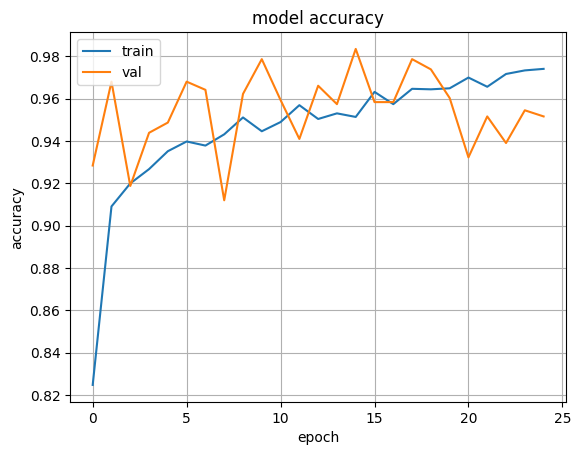

In [56]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.grid()
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()


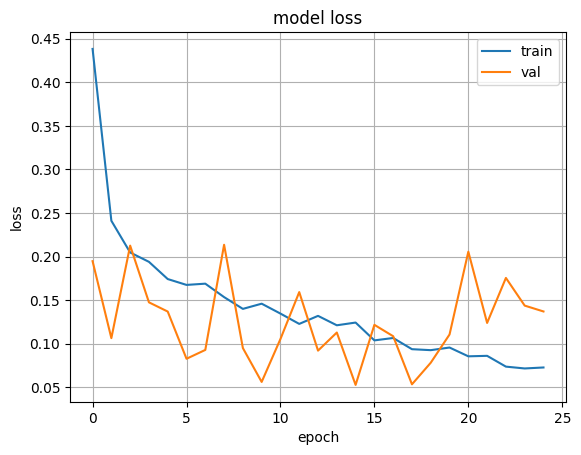

In [57]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid()
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

In [58]:
train_result = model_vgg16.evaluate(X_train, y_train)
test_result = model_vgg16.evaluate(X_test, y_test)
df = pd.DataFrame({'Train': train_result, 'Test': test_result}, index=['Loss', 'Accuracy'])
print(df)


41/41 [==============================] - 32s 790ms/step - loss: 0.1675 - accuracy: 0.9402
             Train      Test
Loss      0.075977  0.167466
Accuracy  0.976209  0.940217


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model_vgg16.predict(X_test), axis=-1)

plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred)
hm = sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
                 xticklabels=['Normal', 'Pneumonia', 'Covid'],
                 yticklabels=['Normal', 'Pneumonia', 'Covid'])
hm.set(xlabel='Predicted Labels', ylabel='True Labels')

print(classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia', 'Covid']))


In [ ]:
model_vgg16.save('model/vgg16.h5')

In [ ]:
covid_images = '/content/drive/MyDrive/images/covid/'
normal_images = '/content/drive/MyDrive/images/normal/'
pneumonia_images = '/content/drive/MyDrive/images/pneumonie/'

In [59]:
covid_images, covid_labels = resize_and_normalize_images(covid_images, 0)
normal_images, normal_labels = resize_and_normalize_images(normal_images, 1)
pneumonia_images,pneumonia_labels = resize_and_normalize_images(pneumonia_images, 2)

<ipython-input-43-4b5f96f64796>:5: DeprecationWarning: listdir: path should be string, bytes, os.PathLike, integer or None, not ndarray
  for image in tqdm(os.listdir(data_directory)):


ValueError: listdir: embedded null character in path

In [ ]:
X_test_images = np.concatenate((covid_images, normal_images, pneumonia_images))
y_test_lables = np.concatenate((covid_labels, normal_labels, pneumonia_labels))


In [64]:
model_vgg16.predict(X_test_images[0:1]).argmax(axis=1)

1/1 [==============================] - 0s 189ms/step


array([0])

In [60]:
results= []
for i in range(10):
    image = X_test_images[i:i+1]
    expected_label = y_test_lables[i]
    pred = model_vgg16.predict(image).argmax(axis=1)[0]
    results.append((f'image{i+1}', pred, expected_label))


1/1 [==============================] - 0s 201ms/step


In [61]:
print("Résultats ")
for result in results:
    print(f"{result[0]} / Prédiction: {result[1]} / Résultats attendus: {result[2]}")


Résultats 
image1 / Prédiction: 0 / Résultats attendus: 0
image2 / Prédiction: 0 / Résultats attendus: 0
image3 / Prédiction: 0 / Résultats attendus: 0
image4 / Prédiction: 0 / Résultats attendus: 0
image5 / Prédiction: 1 / Résultats attendus: 1
image6 / Prédiction: 1 / Résultats attendus: 1
image7 / Prédiction: 1 / Résultats attendus: 1
image8 / Prédiction: 2 / Résultats attendus: 2
image9 / Prédiction: 2 / Résultats attendus: 2
image10 / Prédiction: 2 / Résultats attendus: 2


In [62]:
model_vgg16.evaluate(X_test_images,y_test_lables)

1/1 [==============================] - 0s 326ms/step - loss: 0.0564 - accuracy: 1.0000


[0.05643951892852783, 1.0]